# CME 193 - Lecture 6 Exercise

In this exercise, you'll train a classifier to predict the names of 7 famous politicians from images of their faces.

You'll need the python imaging library for this exercise
```bash
conda install pil
```


In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

%matplotlib inline

We'll use the "Labeled Faces in the Wild" (LFW) dataset.  You can find some information [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)

In [2]:
# Loading the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)



First, we'll gather some information about the data

In [3]:
X = lfw_people.data
n_samples, n_features = X.shape

# the label to predice is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(target_names)
print("\n\n")

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']



Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print("height: %d pixels" % h)
print("width: %d pixels" % w)

height: 50 pixels
width: 37 pixels


In [5]:
# this function will plot a selection of the images
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

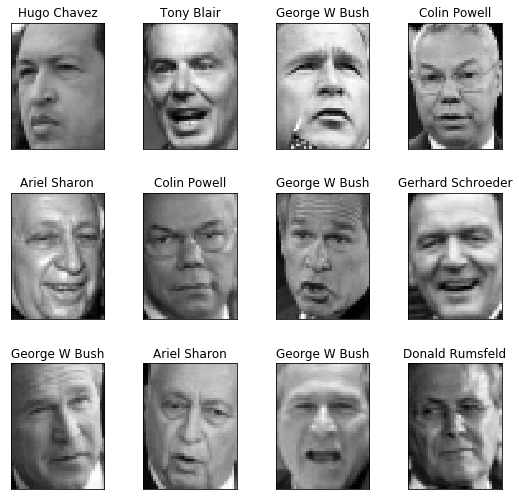

In [6]:
plot_gallery(X, target_names[y], h, w)

If you get an error, you may need to `conda update matplotlib` and restart your kernel

# 1. Split your Data into training and testing sets

Refer to the lecture notes if you don't remember how to do this.

Make the test set 25% of the total dataset

In [ ]:
# your code here

In [7]:
### First step is to split the set into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

# 2. Dimensionality Reduction 

Now since the dimensionality of our input is large (WxH). We use PCA to extract the top principal components of the images. 

PCA is a powerful and widely used linear technique in statistics, signal processing, image processing, and elsewhere. 

In statistics, PCA is a method for simplifying a multidimensional dataset to lower dimensions for analysis, visualization or data compression. 

PCA represents the data in a new coordinate system in which basis vectors follow modes of greatest variance in the data.
 
Consider a 50 X 50 Image: We store the image in a long 1-D row vector by concatenating image pixels column by column (or alternatively row by row), i.e 50 x 50 = 2500 size vector (The huge number 2500 is the dimensionality of our vector space). 

You can read about scikit learn's PCA [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

1. Import the PCA class (from `sklearn.decomposition`)

In [ ]:
# your code here

In [8]:
from sklearn.decomposition import PCA

2. Create a PCA model object.  Use 150 components (keyword `n_components`) and whiten the data (keyword `whiten`).
Refer to [the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) if you're unsure what to do with these keywords.

In [9]:
n_components=150
# your code here

In [10]:
model = PCA(n_components=n_components, whiten=True)

3. Fit the PCA model to your training data (this only involves the design matrix X, not the labels y)

In [ ]:
# your code here

In [11]:
model.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

You now have principal components of your data.  For reasons that will become clear, in this context these components are referred to as "eigenfaces" 

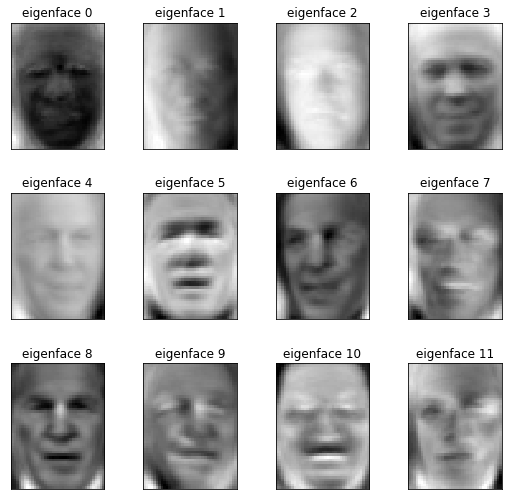

In [12]:
# replace model with whatever you called your PCA model
eigenfaces = model.components_.reshape((n_components, h, w))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

plot_gallery(eigenfaces, eigenface_titles, h, w)

4. Now we're going to transform our data using the PCA coordinates.  Transform both your training and test design matrices (`X`) using the `transform` method.  For example, if my PCA model is called `model`, and my training data is `X_train`, I would write
```python
X_train_pca = model.transform(X_train)
```

In [ ]:
# your code here

In [13]:
X_train_pca = model.transform(X_train)
X_test_pca = model.transform(X_test)

What's the shape for your transoformed matrices? What was the original shape?

In [ ]:
# your code here

In [ ]:
print(X_train.shape)
print(X_train_pca.shape)

### PCA reconstruction

Let's see how our faces look uses just the first n_components principal components to reconstruct the data set
this is done by by multiplying X_train_pca (n_samples, n_componeents) with pca.components_ (n_components, n_features)
    
`pca_model.components_`: is the principal axes in the feature space, representing the directions of maximum variance in the data. The components are sorted by the percentage of the variance they explain

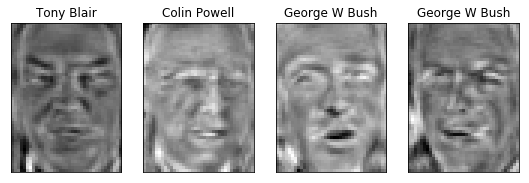

In [14]:
X_train_reconstructed = np.dot(X_train_pca, model.components_)
plot_gallery(X_train_reconstructed, target_names[y_train], h, w, n_row=1)

# 3. Training a Classifier

Here we are using a Support Vector Classifier to classify the dataset (Multiclass classification) and grid searching over the hyperparameters C and gamma:

The constant C > 0 sets the relative importance of maximizing the margin. In other words, the C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.

The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. 

1. import the support vector classifier class from `sklearn.svm` - documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [ ]:
# your code here

In [15]:
from sklearn.svm import SVC

2. Create a SVC model with parameters `C=10, gamma=0.001`

In [ ]:
# your code here

In [16]:
clf = SVC(C=10, gamma=0.001)

3. Fit the model to the PCA-transformed training data

In [17]:
clf.fit(X_train_pca, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

4. Predict labels on your test data, (again use, the PCA-transformed design matrix)

In [ ]:
# your code here

In [18]:
y_pred = clf.predict(X_test_pca)

We'll visualize the true and predicted labels on the test data

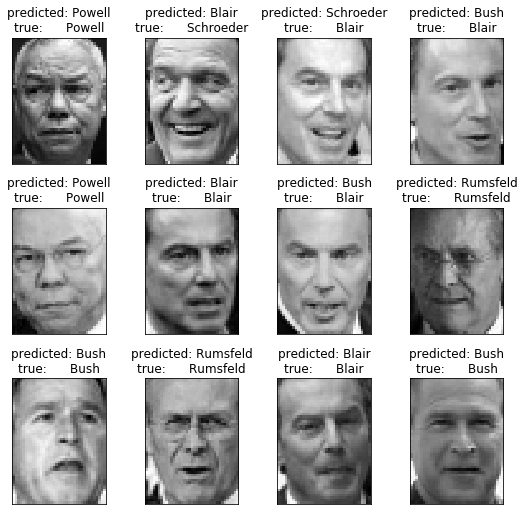

In [19]:
# Qualitative performance
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# Quantitative Evalutaion 

Seeing the results of the model are nice, but we need to break down its performance more rigorously. The cell below uses sklearn's classification report function to generate the [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [f1-score](https://en.wikipedia.org/wiki/F1_score), and support of the names evaluated

In [20]:
from sklearn.metrics import classification_report

# replace y_test and y_pred with your test label and prediction label variable names
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.88      0.78        16
     Colin Powell       0.84      0.76      0.80        55
  Donald Rumsfeld       0.81      0.72      0.76        29
    George W Bush       0.82      0.92      0.87       142
Gerhard Schroeder       0.75      0.65      0.70        23
      Hugo Chavez       0.85      0.79      0.81        14
       Tony Blair       0.91      0.72      0.81        43

        micro avg       0.82      0.82      0.82       322
        macro avg       0.81      0.78      0.79       322
     weighted avg       0.83      0.82      0.82       322



We can also generate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [23]:
from sklearn.metrics import confusion_matrix

# replace y_test and y_pred with your test label and prediction label variable names
cm = confusion_matrix(y_test, y_pred, labels=list(range(n_classes)))
print(cm)

[[ 14   0   1   0   1   0   0]
 [  3  42   1   8   0   0   1]
 [  1   1  21   6   0   0   0]
 [  2   4   2 131   1   2   0]
 [  0   2   0   4  15   0   2]
 [  0   0   0   1   2  11   0]
 [  0   1   1   9   1   0  31]]


# 4. Pipleine

You can chain together several models in a more concise way using sklearn's pipeline

In [25]:
from sklearn.pipeline import Pipeline

pca = PCA(n_components=n_components, whiten=True)
clf = SVC(C=10, gamma=0.001)

pipe = Pipeline(steps=[('pca', pca), ('svc', clf)])

1. Try using the fit and predict methods on the `pipe` object created above

In [26]:
# your code here

In [27]:
pipe = pipe.fit(X_train, y_train)
y_pipe = pipe.predict(X_test)

In [ ]:
pipe.named_steps

2. Print out a classification report of your predictions

In [ ]:
# your code here

In [28]:
print(classification_report(y_test, y_pipe, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.88      0.74        16
     Colin Powell       0.90      0.80      0.85        55
  Donald Rumsfeld       0.81      0.72      0.76        29
    George W Bush       0.82      0.92      0.87       142
Gerhard Schroeder       0.80      0.52      0.63        23
      Hugo Chavez       0.86      0.86      0.86        14
       Tony Blair       0.86      0.72      0.78        43

        micro avg       0.82      0.82      0.82       322
        macro avg       0.81      0.77      0.78       322
     weighted avg       0.83      0.82      0.82       322



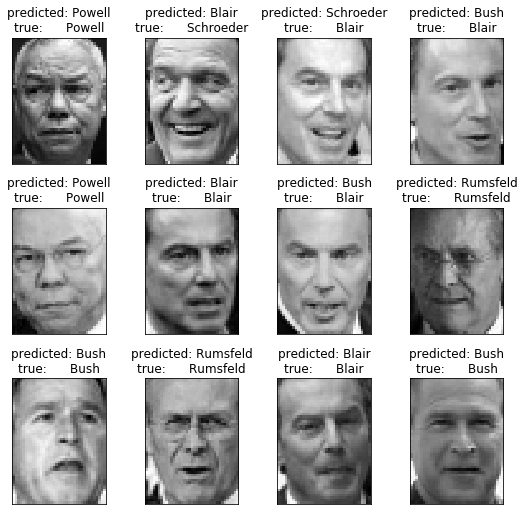

In [29]:
# Qualitative performance
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pipe, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

Attribution:  This exercise is derived from the scikit-learn example [here](http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)